<a href="https://colab.research.google.com/github/Samuel-Mason-git/Recent-Projects/blob/main/Single_Label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-label Classification - Fruit and Veg Image Recognition - Custom CNN, Transfer Learning and Fine Tuning
This project involves building an image recognition model for classifying 36 different categories of fruits and vegetables, with approximately 80 images per class. It combines Custom CNN architecture, Transfer Learning using pre-trained weights from ImageNet, and Fine-Tuning techniques to improve the model's performance. The goal is to accurately classify images of fruits and vegetables into their respective categories.

**Preprocessing**

  *   Understanding Data
  *   Preprocessing
  *   Visualise, Visualise, Visualise
  *   DataGens and Data Augmentation



**Model Model One - Sequential x3 Conv2D, x3 Batch Normalisation, x3 MaxPooling2D, Relu Activation**

---

*   Training - Precision: 0.6650 - Recall: 0.1340 - accuracy: 0.3921 - loss: 2.0476 - val_Precision: 0.8491 - val_Recall: 0.3846 - val_accuracy: 0.6325 - val_loss: 1.2198
*   Evaluation - Test Precision: 0.8528 - Test Recall: 0.3872- Test Loss: 1.2157 - Test Accuracy: 0.632

---

**Model Two - Transfer Learning and Fine Tuning - Imagenet**

---

*   Training - accuracy: 0.8850 - loss: 0.3509 - precision_1: 0.9202 - recall_1: 0.8488 - val_accuracy: 0.9516 - val_loss: 0.2057 - val_precision_1: 0.9680 - val_recall_1: 0.9487
*   Evaluation - Test Loss: 0.1923 - Test Accuracy: 0.9471 - Test Precision: 0.9575 - Test Recall: 0.9415

---



**Evaluation**
Both models show a significant improvement in accuracy, with Model Two (Transfer Learning and Fine-Tuning) outperforming Model One (Custom CNN). The second model achieves high precision, recall, and accuracy on both validation and test sets, highlighting the effectiveness of transfer learning for this task.


In [ ]:
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import os
import zipfile
import shutil
import tensorflow as tf
from shutil import copyfile
from tensorflow.keras.metrics import Precision, Recall
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=1a2dd5e38b6498239e7377fb572214b8eaf906ac3da59a30db69336175348486
  Stored in directory: /root/.cache/pip/wheels/2e/91/a1/2d32c0ea21439c6367fe1acaa2d3a0377a95ae51cf47c13521
Successfully built silence_tensorflow


In [ ]:
!kaggle datasets download kritikseth/fruit-and-vegetable-image-recognition
!unzip /content/fruit-and-vegetable-image-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [00:57<00:00, 43.0MB/s]
100% 1.98G/1.98G [00:57<00:00, 37.0MB/s]
Archive:  /content/fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflatin

In [ ]:
train_dir = '/content/train'
validation_dir = '/content/validation'
test_dir = '/content/test'

### Understanding our Data

*   Number of classes in train folder: 36
*   Number of classes in validation folder: 36
*   Number of classes in test folder: 36



In [ ]:
def num_of_classes(folder_dir, folder_name):
    # Filter to include only directories
    classes = [class_name for class_name in os.listdir(folder_dir)
               if os.path.isdir(os.path.join(folder_dir, class_name))]

    # Print the number of classes
    print(colored(f'Number of classes in {folder_name} folder: {len(classes)}',
                  'blue', attrs=['bold']))

    # Optionally return the number of classes
    return len(classes)

# Example usage:
train_classes = num_of_classes(train_dir, "train")
validation_classes = num_of_classes(validation_dir, "validation")
test_classes = num_of_classes(test_dir, "test")

Number of classes in train folder: 36
Number of classes in validation folder: 36
Number of classes in test folder: 36


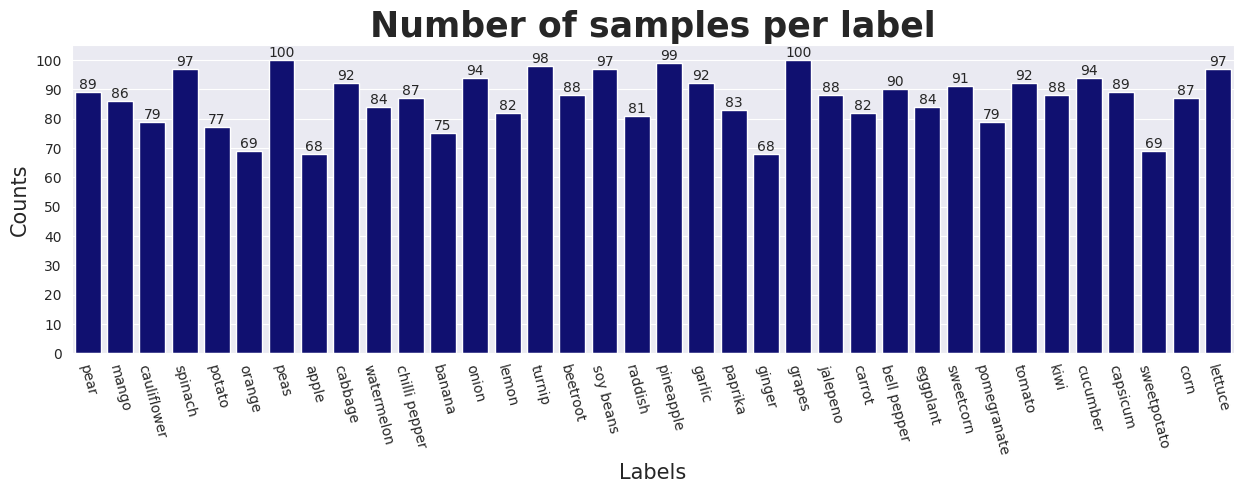

In [ ]:
# work on train folder and count number of samples per each class
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

### Preprocessing
Creating our dataframes ready for data gens

In [ ]:
def create_df(folder_path):
    """
    Create a DataFrame with file paths and class labels.

    Args:
        folder_path (str): Path to the folder containing class subdirectories.

    Returns:
        pd.DataFrame: A DataFrame with columns ['file_path', 'label'].
    """
    all_images = []

    # Get class names (subdirectory names)
    classes = [class_name for class_name in os.listdir(folder_path)
               if os.path.isdir(os.path.join(folder_path, class_name))]

    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)

        # Add (file_path, label) tuples for each file in the class directory
        all_images.extend([(os.path.join(class_path, file_name), class_name)
                           for file_name in os.listdir(class_path)
                           if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))])

    # Create the DataFrame
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

# Example usage:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

# Preview the DataFrame
print(train_df.head())
print(train_df.tail())

                          file_path label
0  /content/train/pear/Image_25.jpg  pear
1  /content/train/pear/Image_43.jpg  pear
2  /content/train/pear/Image_70.jpg  pear
3  /content/train/pear/Image_95.jpg  pear
4  /content/train/pear/Image_31.jpg  pear
                                file_path    label
3110  /content/train/lettuce/Image_92.png  lettuce
3111  /content/train/lettuce/Image_65.jpg  lettuce
3112   /content/train/lettuce/Image_8.jpg  lettuce
3113  /content/train/lettuce/Image_32.jpg  lettuce
3114  /content/train/lettuce/Image_41.jpg  lettuce


In [ ]:
print(colored(f'Number of samples in train : {len(train_df)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'green', attrs=['bold']))

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


### Visualise, Visualise, Visualise

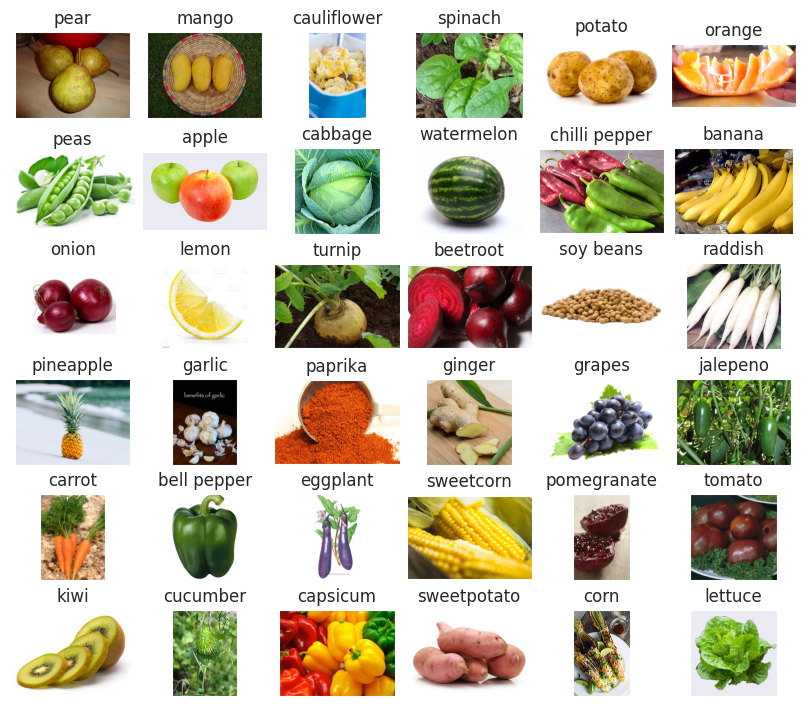

In [ ]:
#Show an image per each class
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

### Datagens with Data Augmentation
Training, Testing and Validation

In [ ]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest',
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 3115 validated image filenames belonging to 36 classes.


In [ ]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [ ]:
#Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=True
)

Found 359 validated image filenames belonging to 36 classes.


### Model One - Sequential x3 Conv2D, x3 Batch Normalisation, x3 MaxPooling2D, Relu Activation.

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        # Input layer with convolution
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),


        # Additional convolutional layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),


        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),


        # Flatten the output for the dense layers
        tf.keras.layers.Flatten(),

        # Fully connected layers without regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation ='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # Output layer
        tf.keras.layers.Dense(36, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573,316 (21.26 MB)

 Trainable params: 5,572,708 (21.26 MB)

 Non-trainable params: 608 (2.38 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Stop if validation loss doesn't improve for 3 epochs
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1
)

In [ ]:
#Train the model
history = model.fit(
    train_generator,
    epochs=100,  # Train for up to 100 epochs, but EarlyStopping will intervene if necessary
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - Precision: 0.1267 - Recall: 0.0074 - accuracy: 0.0714 - loss: 3.9826 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0427 - val_loss: 3.7194
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - Precision: 0.2356 - Recall: 0.0166 - accuracy: 0.1578 - loss: 3.1402 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1425 - val_loss: 3.1366
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - Precision: 0.4132 - Recall: 0.0420 - accuracy: 0.2144 - loss: 2.8048 - val_Precision: 0.2500 - val_Recall: 0.0057 - val_accuracy: 0.2023 - val_loss: 2.7678
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - Precision: 0.4682 - Recall: 0.0504 - accuracy: 0.2367 - loss: 2.6609 - val_Precision: 0.6364 - val_Recall: 0.0399 - val_accuracy: 0.3732 - val_loss: 2.1747
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - Precision: 0.5625 - Recall: 0.0685 - accuracy: 0.2730 - loss: 2.4980 - val_Precision: 0.92

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)

result_df.tail()

,Precision,Recall,accuracy,loss,val_Precision,val_Recall,val_accuracy,val_loss
9,0.627063,0.121990,0.358909,2.157751,0.854545,0.267806,0.564103,1.396574
10,0.646084,0.137721,0.380417,2.084280,0.849057,0.384615,0.632479,1.219816
11,0.594993,0.129695,0.368218,2.100772,0.895161,0.316239,0.629630,1.264573
12,0.661088,0.152167,0.404173,2.008575,0.813953,0.299145,0.578348,1.396565
13,0.654846,0.177849,0.414125,1.948933,0.825581,0.404558,0.618234,1.207790


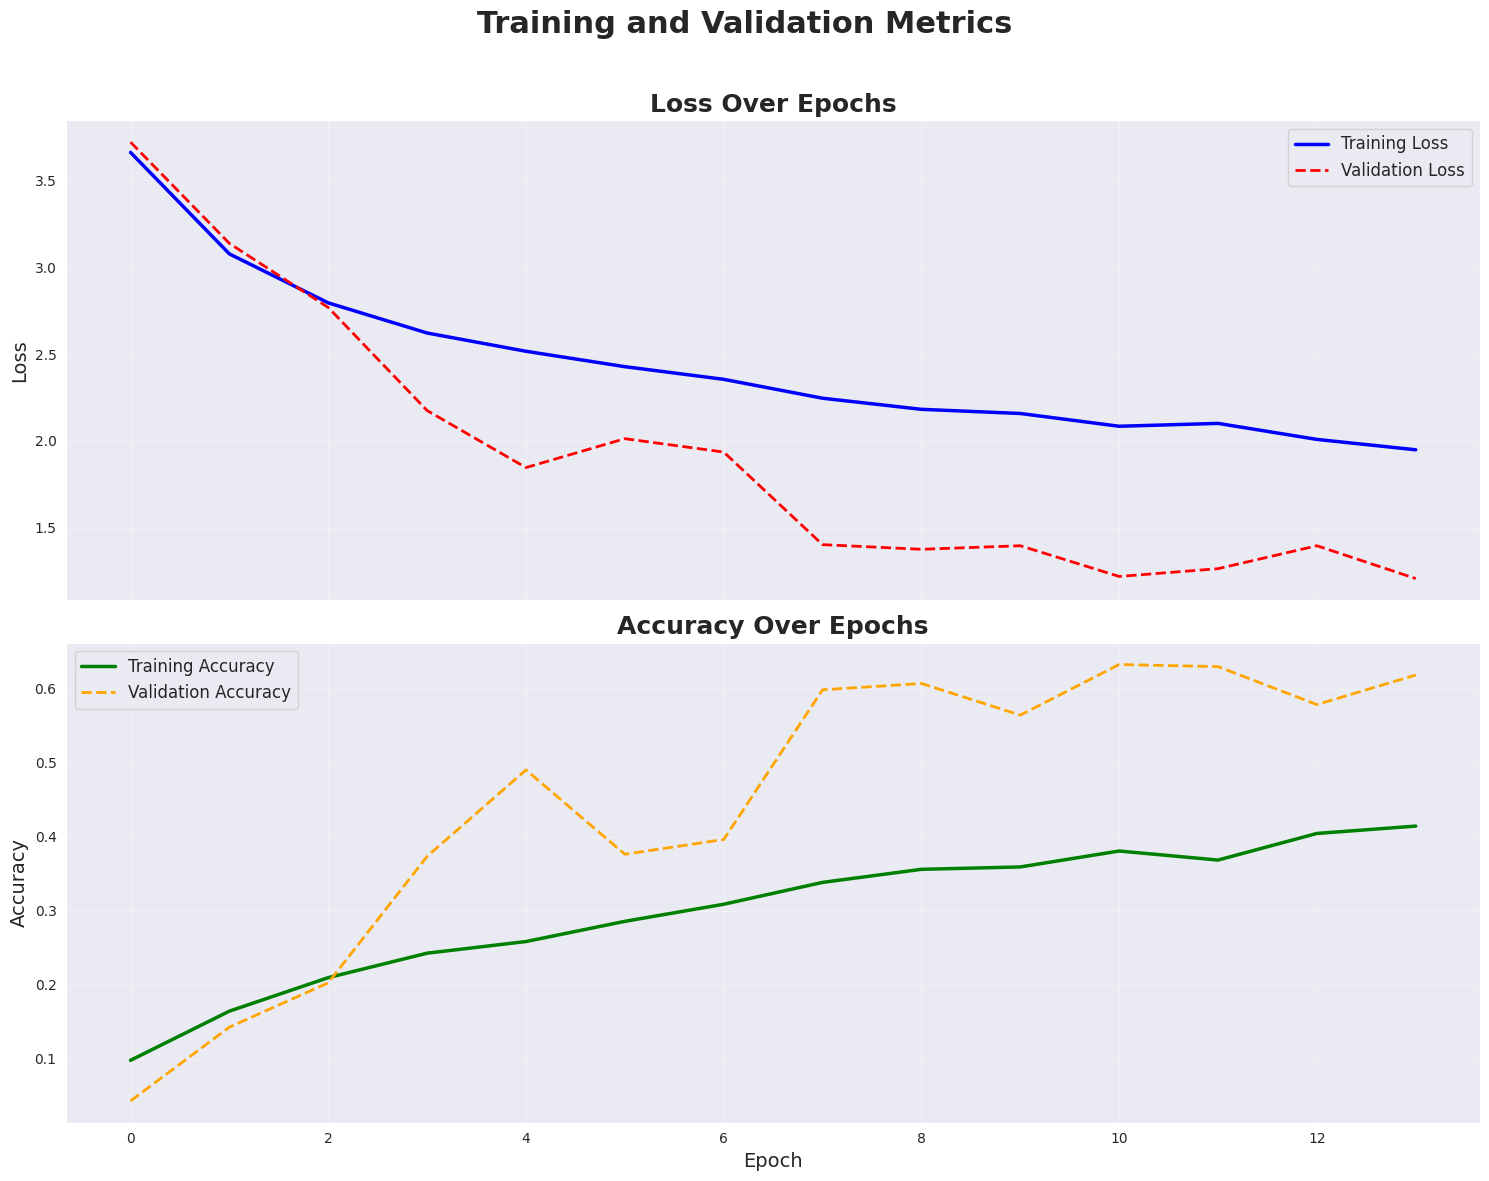

In [ ]:
# Define x-axis values
x = np.arange(len(result_df))

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Define common line properties
line_width_main = 2.5
line_width_secondary = 2

# AX[0]: Loss Plot
ax[0].plot(x, result_df.loss, label='Training Loss', linewidth=line_width_main, color='blue')
ax[0].plot(x, result_df.val_loss, label='Validation Loss', linewidth=line_width_secondary, linestyle='--', color='red')
ax[0].set_title('Loss Over Epochs', fontsize=18, fontweight='bold')
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.3)

# AX[1]: Accuracy Plot
ax[1].plot(x, result_df.accuracy, label='Training Accuracy', linewidth=line_width_main, color='green')
ax[1].plot(x, result_df.val_accuracy, label='Validation Accuracy', linewidth=line_width_secondary, linestyle='--', color='orange')
ax[1].set_title('Accuracy Over Epochs', fontsize=18, fontweight='bold')
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.3)

# Set overall title
fig.suptitle('Training and Validation Metrics', fontsize=22, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

In [ ]:
results = model.evaluate(test_generator)
print("Results:", results)

# Access individual metrics
test_loss = results[0]  # First value is the loss
test_accuracy = results[1]  # Second value is accuracy
# Add other metrics if defined, e.g.:
if len(results) > 2:
    test_precision = results[2]
    test_recall = results[3]
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - Precision: 0.8028 - Recall: 0.3417 - accuracy: 0.6130 - loss: 1.2642
Results: [1.2157498598098755, 0.632311999797821, 0.8527607321739197, 0.38718661665916443]
Test Precision: 0.8528
Test Recall: 0.3872
Test Loss: 1.2157
Test Accuracy: 0.6323


### Model Two - Transfer Learning and Fine Tuning - Imagenet


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Load the MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(36, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()
# Use the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,427,108 (9.26 MB)

 Trainable params: 168,868 (659.64 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.2531 - loss: 3.0795 - precision_1: 0.5340 - recall_1: 0.1106 - val_accuracy: 0.8177 - val_loss: 0.7154 - val_precision_1: 0.9212 - val_recall_1: 0.6325
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6598 - loss: 1.2430 - precision_1: 0.8365 - recall_1: 0.4535 - val_accuracy: 0.8661 - val_loss: 0.4540 - val_precision_1: 0.9208 - val_recall_1: 0.7949
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7163 - loss: 0.9791 - precision_1: 0.8508 - recall_1: 0.5683 - val_accuracy: 0.8860 - val_loss: 0.3565 - val_precision_1: 0.9344 - val_recall_1: 0.8519
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7557 - loss: 0.8128 - precision_1: 0.8769 - recall_1: 0.6489 - val_accuracy: 0.9088 - val_loss: 0.3232 - val_precision_1: 0.9538 - val_recall_1: 0.8832
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7930 - loss: 0.7152 - precision_1: 0.8718 - recall_1: 0.6930 -

In [ ]:
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate on the test set
results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
if len(results) > 2:
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7279 - loss: 0.8864 - precision_2: 0.8146 - recall_2: 0.6598 - val_accuracy: 0.9459 - val_loss: 0.1945 - val_precision_2: 0.9565 - val_recall_2: 0.9402
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7755 - loss: 0.7058 - precision_2: 0.8545 - recall_2: 0.7016 - val_accuracy: 0.9402 - val_loss: 0.2052 - val_precision_2: 0.9504 - val_recall_2: 0.9288
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7995 - loss: 0.6639 - precision_2: 0.8577 - recall_2: 0.7283 - val_accuracy: 0.9373 - val_loss: 0.2071 - val_precision_2: 0.9506 - val_recall_2: 0.9316
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9499 - loss: 0.1600 - precision_2: 0.9600 - recall_2: 0.9470
Test Loss: 0.1923
Test Accuracy: 0.9471
Test Precision: 0.9575
Test Recall: 0.9415
